# Advanced Machine Learning
## Project 1
This project's main goal is to implement and compare optimization algorithms for logistic regression. This involves sourcing and preparing datasets, implementing optimization algorithms and conducting experiments to evaluate their performance using Balanced Accuracy as the metric.

#### Implemented optimization algorithms for parameter estimation in logistic regression:
- **Iterative Reweighted Least Squares**
- **Stochastic Gradient Descent**
- **Adaptive Moment Estimation**

#### Logistic regression classification performance is additionally compared to:
- **Linear and Quadratic Discriminant Analysis**
- **Decision Trees**
- **Random Forest**

### Authors:
1. Michał Ciasnocha
2. Jerzy Kraszewski
3. Filip Kołodziejczyk

In [1]:
# loading necessary libraries
from pathlib import Path
import glob
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from abc import ABC, abstractmethod

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.optim as optim

### Our implementation of optimization algorithms.
Abstract class inherited by IWLS, SGD and ADAM algorithms to provide consistent interface implementation.

In [2]:

class Optimizer(ABC):
    """An abstract class for ML model optimizers"""

    def __init__(self, regularization: float = 0.001):
        self.regularization = regularization

    def gradient(self, X, y, y_pred, params):
        """Calculate the gradient of the loss function with respect to the model's parameters"""
        # Check for bias and adjust if necessary
        if X.shape[1] != params.shape[0]:
            X = np.hstack((X, np.ones((X.shape[0], 1))))

        return X.T @ (y_pred - y) / X.shape[0] + self.regularization * params

    def shuffle_data(self, X, y, y_pred):
        """Shuffle the data for stochastic optimizers"""
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        return X[indices], y[indices], y_pred[indices]

    @abstractmethod
    def update(self, X, y, y_pred, params):
        """Update the model's parameters based on the given data and model"""
        raise NotImplementedError("Subclasses must implement this method")


### IWLS (Iterative Reweighted Least Squares)
IWLS is an optimization algorithm used primarily in statistical modeling, especially for fitting generalized linear models (GLMs). It iteratively updates model parameters to minimize the loss function, typically in cases where the likelihood function is not normally distributed.

## Working Principle

- **Initialization**: The IWLS optimizer is initialized with a regularization parameter, allowing for regularization during optimization.
- **Hessian Calculation**: The `hessian` method calculates the Hessian matrix of the loss function with respect to the model's parameters.
- **Parameter Update**: The `update` method updates model parameters iteratively using the IWLS algorithm. It computes the gradient of the loss function and updates the parameters based on the inverse of the Hessian matrix.
- **Convergence**: The iterative update process continues until it meets the stopping criteria.


In [3]:
class IWLS(Optimizer):
    """Iteratively reweighted least squares optimizer"""

    def __init__(self, regularization: float = 0.001):
        super().__init__(regularization=regularization)

    def hessian(self, X, y_pred, params):
        """Calculate the Hessian of the loss function with respect to the model's parameters"""
        # Check for bias and adjust if necessary
        if X.shape[1] != params.shape[0]:
            X = np.hstack((X, np.ones((X.shape[0], 1))))

        W = np.diag(y_pred * (1 - y_pred))
        return X.T @ W @ X / X.shape[0] + self.regularization * np.eye(params.shape[0])

    def update(self, X, y, y_pred, params):
        grad = self.gradient(X, y, y_pred, params)
        hessian = self.hessian(X, y_pred, params)
        params -= np.linalg.inv(hessian) @ grad
        return params


### SGD (Stochastic Gradient Descent)
SGD is widely used for training various machine learning models, including linear models, neural networks, and deep learning models. It is particularly suitable for large-scale datasets and online learning scenarios where processing the entire dataset at once is impractical.

### Working principle

- **Initialization**: The SGD optimizer is initialized with parameters including learning rate, batch size, and regularization.
- **Data Shuffling**: Before iterating through the data, it shuffles the input features, true labels, and predicted values to ensure randomness in each iteration.
- **Batch Update**: SGD updates model parameters in mini-batches. It iterates through the data in batches, computing the gradient of the loss function for each batch and updating the parameters accordingly using the learning rate.
- **Convergence**: The iterative update process continues until convergence criteria are met or a predefined number of iterations is reached.


In [4]:
class SGD(Optimizer):
    """Stochastic Gradient Descent optimizer"""

    def __init__(self, learning_rate: float = 0.001, batch_size: int = 16, regularization: float = 0.001):
        super().__init__(regularization=regularization)
        self.learning_rate = learning_rate
        self.batch_size = batch_size

    def update(self, X, y, y_pred, params):
        X, y, y_pred = self.shuffle_data(X, y, y_pred)

        # Go through the data in batches
        for i in range(0, X.shape[0], self.batch_size):
            X_batch = X[i : i + self.batch_size]
            y_batch = y[i : i + self.batch_size]
            y_pred_batch = y_pred[i : i + self.batch_size]
            grad = self.gradient(X_batch, y_batch, y_pred_batch, params)
            params -= self.learning_rate * grad

        return params

### ADAM (Adaptive Moment Estimation)
Adam optimizer is commonly used for training deep neural networks due to its adaptive learning rate properties and computational efficiency. It performs well on a wide range of deep learning tasks and is often the optimizer of choice for many state-of-the-art models.

### Working principle
- **Initialization**: Adam optimizer is initialized with parameters including learning rate, beta1 (exponential decay rate for the first moment estimate), beta2 (exponential decay rate for the second moment estimate), epsilon (smoothing term to prevent division by zero), batch size, and regularization.
- **Data Shuffling**: Similar to SGD, Adam shuffles the input features, true labels, and predicted values before iterating through the data to ensure randomness in each iteration.
- **Batch Update**: Adam updates model parameters in mini-batches. It computes the gradient of the loss function for each batch and updates the parameters using adaptive learning rates computed based on estimates of first and second moments of the gradients.
- **Exponential Decay and Bias Correction**: Adam applies exponential decay to the first and second moment estimates of the gradients and corrects the bias introduced during the initialization.
- **Convergence**: The iterative update process continues until convergence criteria are met or a predefined number of iterations is reached.


In [5]:
class ADAM(Optimizer):
    """Adaptive Moment Estimation optimizer"""

    def __init__(
        self,
        learning_rate: float = 0.001,
        beta1: float = 0.9,
        beta2: float = 0.999,
        epsilon: float = 1e-8,
        batch_size: int = 16,
        regularization: float = 0.001,
    ):
        super().__init__(regularization=regularization)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.first_moment = None
        self.second_moment = None
        self.iteration = 0

    def update(self, X, y, y_pred, params):
        self.iteration += 1
        if self.first_moment is None:
            self.first_moment = np.zeros(params.shape)
            self.second_moment = np.zeros(params.shape)

        X, y, y_pred = self.shuffle_data(X, y, y_pred)

        # Go through the data in batches
        for i in range(0, X.shape[0], self.batch_size):
            X_batch = X[i : i + self.batch_size]
            y_batch = y[i : i + self.batch_size]
            y_pred_batch = y_pred[i : i + self.batch_size]

            grad = self.gradient(X_batch, y_batch, y_pred_batch, params)
            self.first_moment = self.beta1 * self.first_moment + (1 - self.beta1) * grad
            self.second_moment = self.beta2 * self.second_moment + (1 - self.beta2) * grad**2

            # Bias correction
            first_moment_corr = self.first_moment / (1 - self.beta1**self.iteration)
            second_moment_corr = self.second_moment / (1 - self.beta2**self.iteration)

            params -= self.learning_rate * first_moment_corr / (np.sqrt(second_moment_corr) + self.epsilon)

        
        return params

### Logistic Regression
Logistic regression is commonly used in binary classification tasks such as spam detection, credit scoring, and medical diagnosis. It serves as a simple yet effective model for interpreting the relationship between input features and the probability of the positive class.

### Working principle

- **Initialization**: The logistic regression model initializes with weights and bias parameters.
- **Fitting**: The `fit` method trains the logistic regression model using an optimization algorithm (provided as an argument), updating model parameters iteratively to minimize the loss function.
- **Prediction**: The `predict_proba` method computes the probability of the positive class, while the `predict` method makes binary predictions based on a threshold of 0.5.
- **Loss Function**: The model utilizes binary cross-entropy loss to measure the difference between predicted and true labels.

### Training 

- **Parameter Initialization**: Model parameters (weights and bias) are initialized randomly.
- **Gradient Descent**: The model utilizes an optimization algorithm to update parameters iteratively, minimizing the binary cross-entropy loss.
- **Convergence**: Training continues until the change in loss function falls below a predefined tolerance level or a maximum number of epochs is reached.


In [6]:
class LogisticRegression:
    def __init__(self):
        self.weights = None
        self.bias = 0

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    def predict_proba(self, X):
        z = X @ self.weights + self.bias
        z = np.clip(z, -100, 100)  # Preventing overflow
        return self.sigmoid(z)

    @staticmethod
    def binary_cross_entropy(y, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # Preventing log(0) and log(1)
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

    def fit(
        self,
        X,
        y,
        optimizer: Optimizer,
        max_epochs: int = 500,
        tolerance: float = 0.001,
    ):
        self.weights = np.random.normal(0, 0.01, X.shape[1])
        loss_history = [-np.inf]

        for _ in range(max_epochs):
            params = np.concatenate((self.weights, [self.bias]))
            new_params = optimizer.update(X, y, self.predict_proba(X), params)

            self.weights = new_params[:-1]
            self.bias = new_params[-1]
            loss_history.append(self.binary_cross_entropy(y, self.predict_proba(X)))

            if abs(loss_history[-1] - loss_history[-2]) <= tolerance:
                break

        return loss_history[1:]

### Interaction generation function
Generating interaction terms is a common preprocessing step in machine learning tasks. It allows the model to capture interactions between input features, potentially improving its predictive performance at a cost in time.

In [7]:
def generate_interactions(X):
    num_samples, num_features = X.shape

    interaction_data = []
    for i in range(num_features - 1):
        for j in range(i + 1, num_features):
            interaction_terms = X[:, i] * X[:, j]
            interaction_data.append(interaction_terms)

    interaction_data = np.column_stack(interaction_data)

    return np.concatenate((X, interaction_data), axis=1)

# Methodology
## Dataset summary:
In this project, a total of nine datasets were collected and preprocessed for experimentation. The datasets were sourced from UCI Machine Learning Repository.
Details of the datasets and preprocessing process can be found in `DATASETS.md` markdown and `preprocessing.ipynb` notebook
### Small Datasets:

1. [National Health and Nutrition Health Survey 2013-2014 (NHANES) Age Prediction Subset](https://archive.ics.uci.edu/dataset/887/national+health+and+nutrition+health+survey+2013-2014+(nhanes)+age+prediction+subset)
2. [Ajwa or Medjool](https://archive.ics.uci.edu/dataset/879/ajwa+or+medjool)
3. [Fertility Dataset](https://archive.ics.uci.edu/dataset/244/fertility)

### Large Datasets

1. [Mice Protein Expression](https://archive.ics.uci.edu/dataset/342/mice+protein+expression)
2. [Mushroom Dataset](https://archive.ics.uci.edu/dataset/73/mushroom)
3. [Room Occupancy Estimation](https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation)
4. [Taiwanese Bankruptcy Prediction](https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction)
5. [Estimation of Obesity Levels](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition)
6. [Wine Color](https://archive.ics.uci.edu/dataset/186/wine+quality)

## Stopping Rule

```python
loss_history.append(self.binary_cross_entropy(y, self.predict_proba(X)))
if abs(loss_history[-1] - loss_history[-2]) <= tolerance:
    break
```
The stopping rule is implemented within a training loop, which is a commonly used approach. In this context, the stopping rule is based on the change in the binary cross-entropy loss between consecutive iterations, with a tolerance set to 1e-4.

- The stopping rule ensures that the training process terminates when the change in loss becomes negligible, indicating convergence to a stable solution.

- By setting a tolerance threshold, the algorithm can avoid unnecessary computation and iterations once the convergence criteria are met, improving efficiency.

- Tolerance values such as 1e-4 are commonly chosen based on empirical observations and may vary depending on the specific problem and algorithm convergence behavior.

## Balanced accuracy

- **Balanced Accuracy**: The function computes the sensitivity and specificity for each class and then averages them to obtain the balanced accuracy.
  
- **Handling Imbalanced Classes**: It is particularly useful when dealing with imbalanced datasets, where the number of samples in different classes is unequal. In such cases, the balanced accuracy provides a more accurate evaluation metric than traditional accuracy, which may be biased towards the majority class.
  
- **Binary and Multiclass Classification**: It can be used for both binary and multiclass classification tasks.

- **Classifier Comparison**: It can compare different classifiers, allowing for a fair assessment of their performance across different classes.


In [8]:
# loading datasets
folder_path = 'datasets'
csv_files = glob.glob(folder_path + '/*.csv')
dfs = {}
file_names = []

for file in csv_files:
    file_name = Path(file).stem
    file_names.append(file_name)
    dfs[file_name] = pd.read_csv(file)
    print(file_name)


nhanes_survey_age_prediction
mice_protein_expression
ajwa_or_medjool
mushroom_classification
obesity_levels
wine_color_classification
taiwanese_bankruptcy_prediction
fertility
room_occupancy_estimation


In [9]:
# setting hyperparams
max_epochs = 500
tolerance = 1e-4
test_size = 0.2
batch_size = 16
standarize = True
num_splits = 5

In [10]:
# splitting datasets
Xs = {}
ys = {}

Xs_train = [None] * num_splits
Xs_test = [None] * num_splits
ys_train = [None] * num_splits
ys_test = [None] * num_splits

for i in range(num_splits):
    Xs_train[i] = {}
    Xs_test[i] = {}
    ys_train[i] = {}
    ys_test[i] = {}

for file_name in file_names:
    # note that every dataset target value column has been called appropriately during preprocessing
    Xs[file_name] = dfs[file_name].drop(columns=['target']).values
    ys[file_name] = dfs[file_name]['target'].values
    
        
    for i in range(num_splits):
        X_train, X_test, y_train, y_test = train_test_split(Xs[file_name], ys[file_name], test_size=test_size)
        
        if standarize:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        # append split
        Xs_train[i][file_name] = X_train
        Xs_test[i][file_name] = X_test
        ys_train[i][file_name] = y_train
        ys_test[i][file_name] = y_test


In [11]:
# add output folder if non-existent
if not os.path.exists('outputs'):
    os.system('mkdir outputs')

In [12]:
# don't mind me
import warnings
warnings.filterwarnings("ignore", message="Variables are collinear")
warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")

### Implementations of Performed Experiments

##### `run_classifier_experiment`

This function performs a classification experiment using a given classifier (LDA, QDA, Decision Tree, Random Forest). It trains the selected classifier on the training data (`X_train`, `y_train`), makes predictions on the test data (`X_test`), and calculates the balanced accuracy score.

##### `run_custom_optimizer_experiment`

This function conducts an experiment using our implemetation of optimizers for logistic regression (Adam, IWLS, SGD). It trains a logistic regression model with the specified optimizer, tolerance, and maximum epochs on the training data (`X_train`, `y_train`). It then evaluates the model's performance on the test data (`X_test`, `y_test`) and returns the balanced accuracy score along with weight changes during training.

##### `run_pytorch_experiment`

This function performs an experiment using PyTorch for logistic regression. It trains a logistic regression model with the specified optimizer (either Adam or SGD), provided by PyTorch library. Its purpose is to provide a good comparison for our implementation.


In [13]:
def run_classifier_experiment(
    classifier,
    X_train,
    y_train,
    X_test,
    y_test
):
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    balanced_acc = balanced_accuracy_score(y_test, predictions)
    return balanced_acc


# Custom Optimizer Experiment Function
def run_custom_optimizer_experiment(
    optimizer,
    X_train,
    y_train,
    X_test,
    y_test,
    tolerance,
    max_epochs
):

    log_reg = LogisticRegression()
    weight_changes = log_reg.fit(X_train, y_train, optimizer, max_epochs, tolerance)
    predictions = log_reg.predict(X_test)
    balanced_acc = balanced_accuracy_score(y_test, predictions)
    return balanced_acc, weight_changes

# Convergence analysis
Convergence analysis is conducted to observe how the function's binary cross-enropy value changes with the number of iterations for each algorithm on the training data for every dataset. This analysis helps to understand how quickly each algorithm can converge and their stability during training on different datasets.

### Steps:

1. **Training Loop**: Each algorithm is trained on the training data for multiple epochs. The binary cross-entropy value is calculated at each iteration to monitor convergence.

2. **Binary Cross-Entropy Calculation**: A function is defined to compute the value based on the current model parameters and training data.

```python
def binary_cross_entropy(y, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # Preventing log(0) and log(1)
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
```
3. **Convergence Check**: The training loop continues until convergence criteria are met, i.e., when the change in BCE loss falls below a predefined tolerance level. <br>Tolerance was determined as 1e-4.


```python
loss_history.append(self.binary_cross_entropy(y, self.predict_proba(X)))
if abs(loss_history[-1] - loss_history[-2]) <= tolerance:
    break
```


4. **Visualization**: The binary cross-entropy loss values are plotted against the number of iterations for each algorithm for each dataset to visualize their convergence behavior.


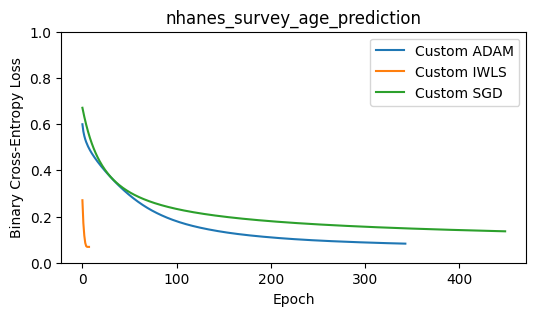

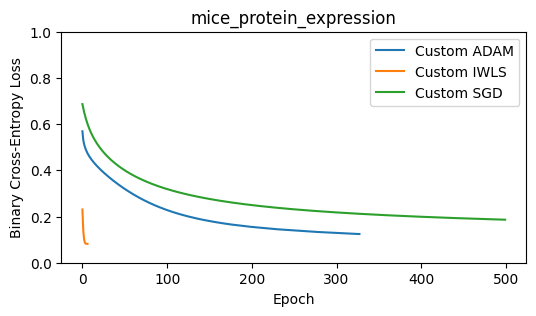

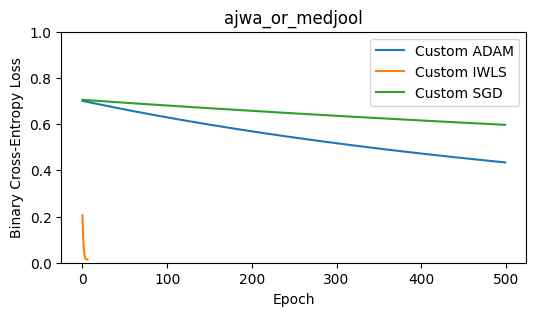

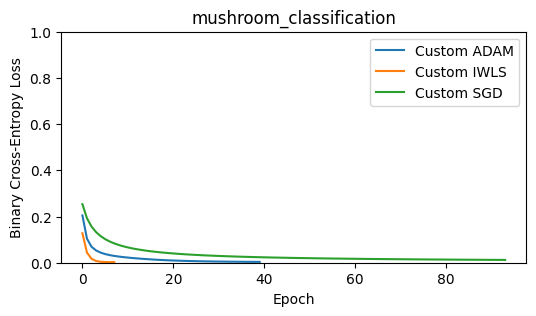

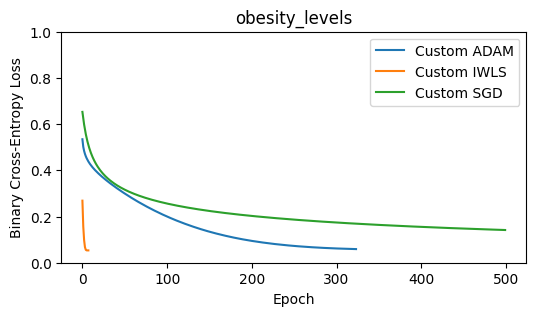

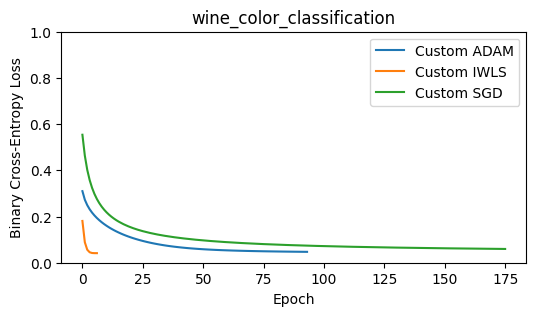

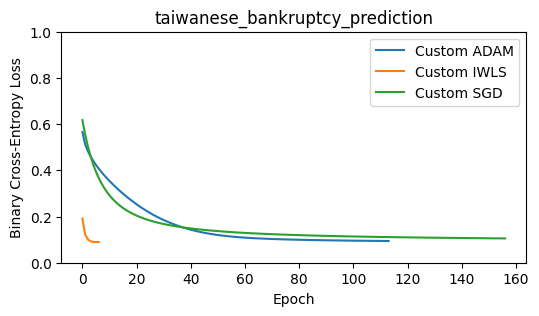

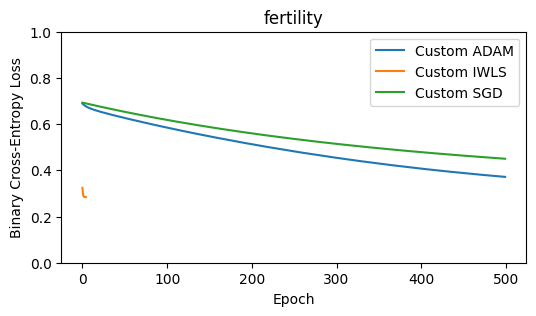

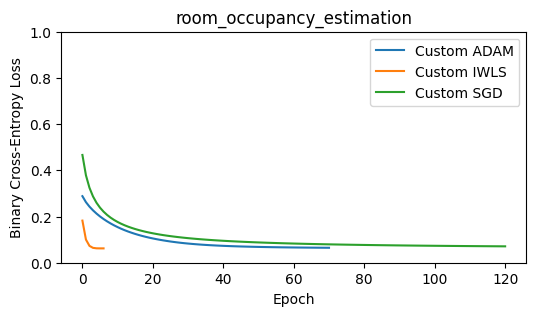

In [14]:
# for each dataset
for file_name in file_names:
    adam = ADAM(batch_size=batch_size)
    iwsl = IWLS()
    sgd = SGD(batch_size=batch_size)

    # run experiments
    custom_adam_acc, adam_weight_changes = run_custom_optimizer_experiment(
        adam, Xs_train[0][file_name], ys_train[0][file_name], Xs_test[0][file_name], ys_test[0][file_name], tolerance, max_epochs
    )
    custom_iwls_acc, iwls_weight_changes = run_custom_optimizer_experiment(
        iwsl, Xs_train[0][file_name], ys_train[0][file_name], Xs_test[0][file_name], ys_test[0][file_name], tolerance, max_epochs
    )
    custom_sgd_acc, sgd_weight_changes = run_custom_optimizer_experiment(
        sgd, Xs_train[0][file_name], ys_train[0][file_name], Xs_test[0][file_name], ys_test[0][file_name], tolerance, max_epochs
    )

    # plot convergences
    plt.figure(figsize=(6, 3))
    plt.plot(adam_weight_changes, label="Custom ADAM")
    plt.plot(iwls_weight_changes, label="Custom IWLS")
    plt.plot(sgd_weight_changes, label="Custom SGD")

    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy Loss")
    plt.ylim(0, 1)
    plt.title(f"{file_name}")
    plt.legend()
    plt.savefig(f"outputs/{file_name}_converge.pdf", bbox_inches='tight')

# Comparison of classification performance
In the comparison of classification performance, we used balanced accuracy as a metric to evaluate the effectiveness of different classifiers in various datasets. Balanced accuracy takes into account the class imbalance in the dataset. This provides a more reliable measure of classifier performance, especially in situations where the classes are imbalanced.
By comparing the balanced accuracy scores across different classifiers and optimization algorithms, we can observe their relative performance and suitability for the specific classification task and dataset.

1. **Balanced Accuracy Score Calculation**: The `balanced_accuracy_score` function from scikit-learn is used to compute the balanced accuracy score for each classifier and optimization algorithm on the test data.

2. **Experimental Setup**: For each dataset, experiments are conducted with various classifiers (e.g., Linear Discriminant Analysis, Decision Trees, Custom Optimizers such as ADAM, IWLS, SGD, etc.).

3. **Plotting**: The balanced accuracy scores obtained from the experiments are plotted using bar charts, with the classifiers sorted based on their accuracy scores.

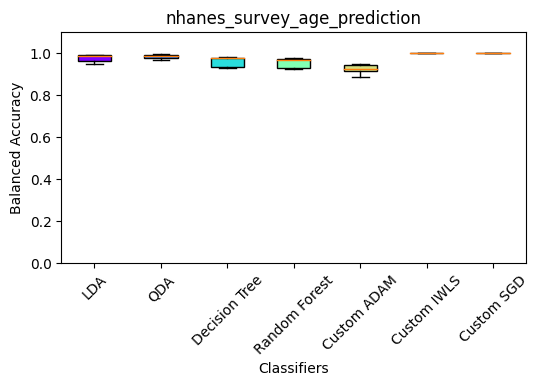

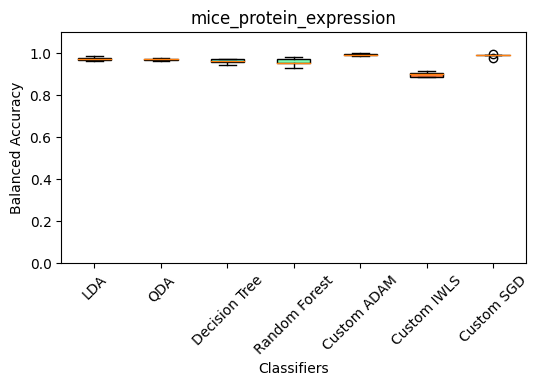

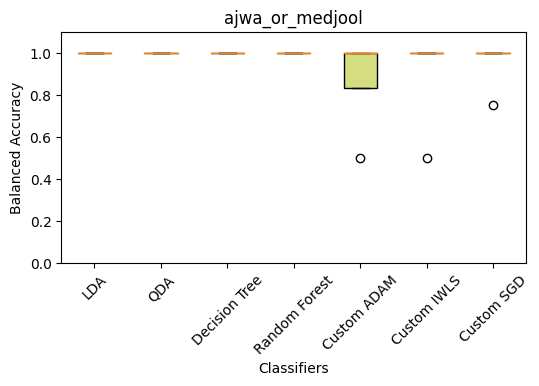

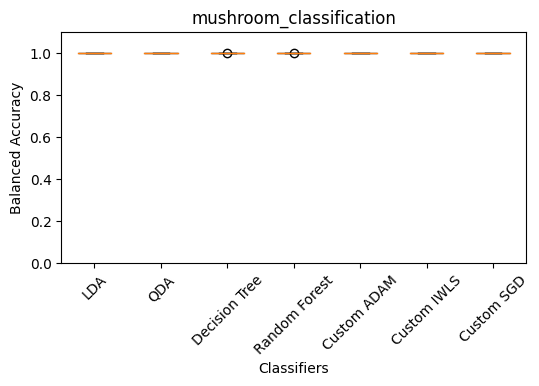

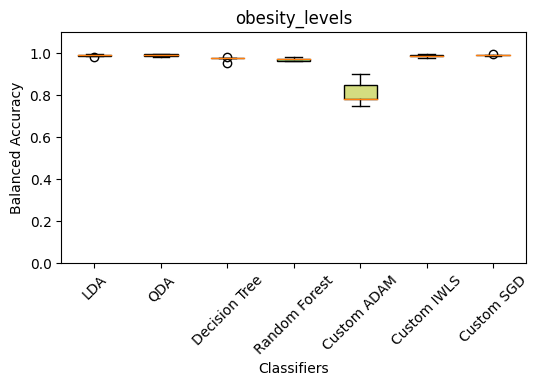

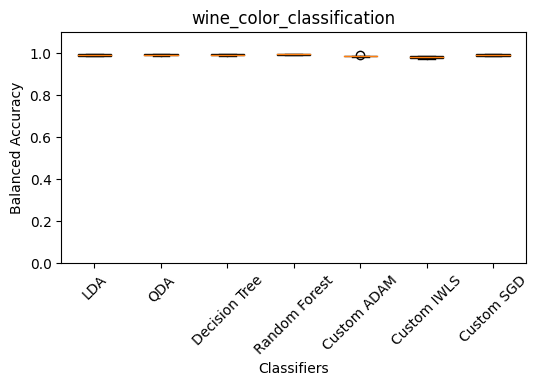

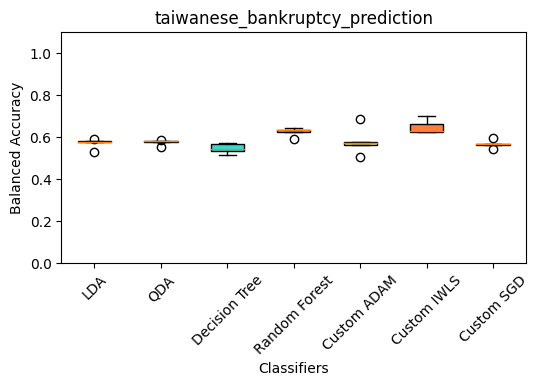

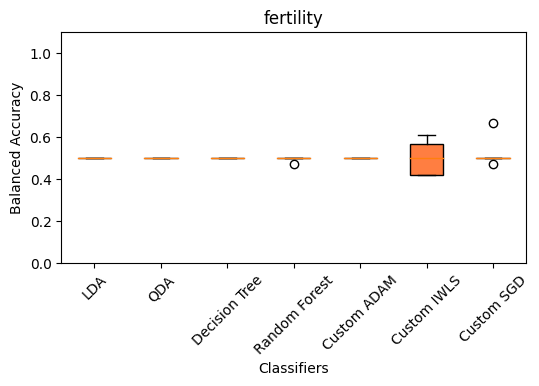

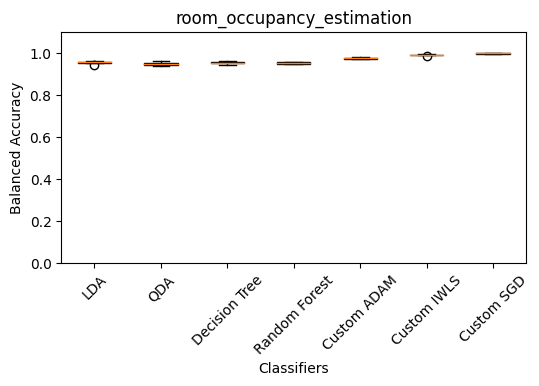

In [15]:
avg_custom_adam_accs = []
avg_custom_iwls_accs = []
avg_custom_sgd_accs = []
avg_lda_accs = []
avg_qda_accs = []
avg_dt_accs = []
avg_rf_accs = []

# for each dataset
for file_name in file_names:

    # Initialize lists to store accuracies for each split
    custom_adam_accs = []
    custom_iwls_accs = []
    custom_sgd_accs = []
    lda_accs = []
    qda_accs = []
    dt_accs = []
    rf_accs = []

    for i in range(num_splits):

        adam = ADAM(batch_size=batch_size)
        iwsl = IWLS()
        sgd = SGD(batch_size=batch_size)

        custom_adam_acc, _ = run_custom_optimizer_experiment(
            adam, Xs_train[i][file_name], ys_train[i][file_name], Xs_test[i][file_name], ys_test[i][file_name], tolerance, max_epochs
        )
        custom_iwls_acc, _ = run_custom_optimizer_experiment(
            iwsl, Xs_train[i][file_name], ys_train[i][file_name], Xs_test[i][file_name], ys_test[i][file_name], tolerance, max_epochs
        )
        custom_sgd_acc, _ = run_custom_optimizer_experiment(
            sgd, Xs_train[i][file_name], ys_train[i][file_name], Xs_test[i][file_name], ys_test[i][file_name], tolerance, max_epochs
        )

        # prepare classifiers
        lda = LinearDiscriminantAnalysis()
        qda = QuadraticDiscriminantAnalysis()
        dt = DecisionTreeClassifier()
        rf = RandomForestClassifier()

        lda_accuracy = run_classifier_experiment(lda, Xs_train[i][file_name], ys_train[i][file_name], Xs_test[i][file_name], ys_test[i][file_name])
        qda_accuracy = run_classifier_experiment(qda, Xs_train[i][file_name], ys_train[i][file_name], Xs_test[i][file_name], ys_test[i][file_name])
        dt_accuracy = run_classifier_experiment(dt, Xs_train[i][file_name], ys_train[i][file_name], Xs_test[i][file_name], ys_test[i][file_name])
        rf_accuracy = run_classifier_experiment(rf, Xs_train[i][file_name], ys_train[i][file_name], Xs_test[i][file_name], ys_test[i][file_name])

        # save results
        custom_adam_accs.append(custom_adam_acc)
        custom_iwls_accs.append(custom_iwls_acc)
        custom_sgd_accs.append(custom_sgd_acc)
        lda_accs.append(lda_accuracy)
        qda_accs.append(qda_accuracy)
        dt_accs.append(dt_accuracy)
        rf_accs.append(rf_accuracy)

    avg_custom_adam_accs.append(sum(custom_adam_accs) / num_splits)
    avg_custom_iwls_accs.append(sum(custom_iwls_accs) / num_splits)
    avg_custom_sgd_accs.append(sum(custom_sgd_accs) / num_splits)
    avg_lda_accs.append(sum(lda_accs) / num_splits)
    avg_qda_accs.append(sum(qda_accs) / num_splits)
    avg_dt_accs.append(sum(dt_accs) / num_splits)
    avg_rf_accs.append(sum(rf_accs) / num_splits)

    classifiers = ['LDA', 'QDA', 'Decision Tree', 'Random Forest', 'Custom ADAM', 'Custom IWLS', 'Custom SGD']
    
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classifiers)))

    data = [custom_adam_accs, custom_iwls_accs, custom_sgd_accs, lda_accs, qda_accs, dt_accs, rf_accs]
    plt.figure(figsize=(6, 3))
    box = plt.boxplot(data, patch_artist=True)
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.xlabel('Classifiers')
    plt.ylabel('Balanced Accuracy')
    plt.title(file_name)
    plt.xticks(range(1, len(classifiers) + 1), classifiers, rotation=45)
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.savefig(f"outputs/{file_name}_accur.pdf", bbox_inches='tight')


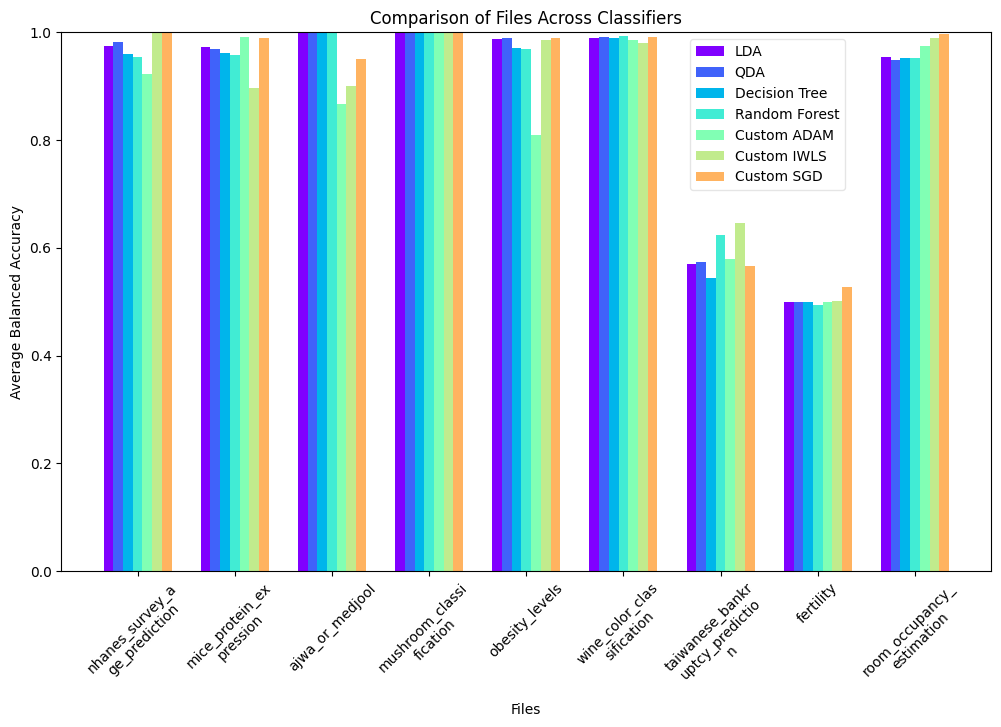

In [16]:
import textwrap
# Prepare data for plotting
classifiers = ['LDA', 'QDA', 'Decision Tree', 'Random Forest', 'Custom ADAM', 'Custom IWLS', 'Custom SGD']
data = np.array([avg_custom_adam_accs, avg_custom_iwls_accs, avg_custom_sgd_accs, avg_lda_accs, avg_qda_accs, avg_dt_accs, avg_rf_accs])

# Define colors using a colormap
colors = plt.cm.rainbow(np.linspace(0, 1, len(file_names)))

# Plot
plt.figure(figsize=(12, 7))
for i, classifier in enumerate(classifiers):
    plt.bar(np.arange(len(file_names)) + i * 0.1, data[i], width=0.1, color=colors[i], label=classifier)

# Wrap the text of file names
wrapped_file_names = [textwrap.fill(name, width=15) for name in file_names]
plt.xlabel('Files', wrap=True)
plt.ylabel('Average Balanced Accuracy')
plt.title('Comparison of Files Across Classifiers')
plt.xticks(np.arange(len(file_names)) + 0.3, wrapped_file_names, rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(0.85, 1), framealpha=0.5)
plt.ylim(0, 1)

# Save the plot
plt.savefig("outputs/files_comparison_bar_chart.pdf", bbox_inches='tight')
plt.show()

# Comparison of classification of models with and without interactions

In this comparison, we test the effects of adding interaction terms to the features. Specifically, classification performance of various optimization algorithms is examined. The balanced accuracy score is used again, as the evaluation metric to assess the performance of classifiers with and without interaction terms in selected datasets. By comparing the convergence behavior and balanced accuracy scores of classifiers with and without interaction terms, insights can be gained into the impact of feature interactions on classification performance.

### Steps:

1. **Data Preparation**: Interaction terms are generated for the feature space of each dataset.

2. **Experimental Setup**: For each dataset, experiments are conducted with various optimization algorithms (our implementations of ADAM, IWLS, SGD) using both the original features and the features augmented with interaction terms.

3. **Performance Evaluation**: The balanced accuracy scores are computed for each classifier with and without interaction terms on the test data.

4. **Plotting**: The convergence behavior of the optimization algorithms with and without interaction terms is visualized using line plots, with the binary cross-entropy loss plotted against the number of epochs for each algorithm.


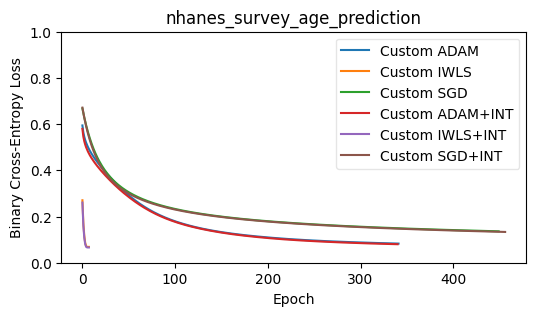

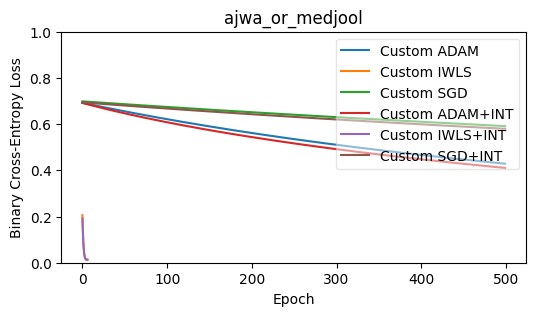

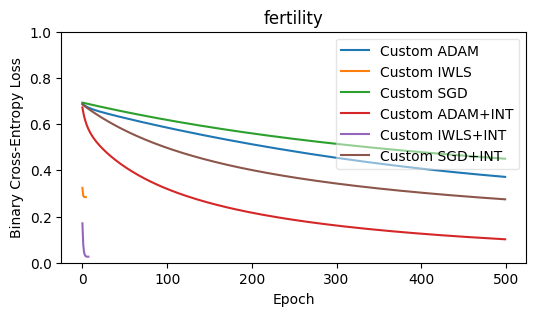

In [17]:
# for each dataset
Xs_train_int = {}
Xs_test_int = {}
for file_name in file_names:

    # disregard large datasets
    if file_name not in ['nhanes_survey_age_prediction', 'ajwa_or_medjool', 'fertility']:
        continue
    adam = ADAM(batch_size=batch_size)
    iwsl = IWLS()
    sgd = SGD(batch_size=batch_size)

    # run experiments
    custom_adam_acc, adam_weight_changes = run_custom_optimizer_experiment(
        adam, Xs_train[0][file_name], ys_train[0][file_name], Xs_test[0][file_name], ys_test[0][file_name], tolerance, max_epochs
    )
    custom_iwls_acc, iwls_weight_changes = run_custom_optimizer_experiment(
        iwsl, Xs_train[0][file_name], ys_train[0][file_name], Xs_test[0][file_name], ys_test[0][file_name], tolerance, max_epochs
    )
    custom_sgd_acc, sgd_weight_changes = run_custom_optimizer_experiment(
        sgd, Xs_train[0][file_name], ys_train[0][file_name], Xs_test[0][file_name], ys_test[0][file_name], tolerance, max_epochs
    )

    # generate interactions
    Xs_train_int[file_name] = generate_interactions(Xs_train[0][file_name])
    Xs_test_int[file_name] = generate_interactions(Xs_test[0][file_name])

    # prepare datasets
    adam = ADAM(batch_size=batch_size)
    iwsl = IWLS()
    sgd = SGD(batch_size=batch_size)

    custom_adam_acc_int, adam_weight_changes_int = run_custom_optimizer_experiment(
        adam, Xs_train_int[file_name], ys_train[0][file_name], Xs_test_int[file_name], ys_test[0][file_name], tolerance, max_epochs
    )
    custom_iwls_acc_int, iwls_weight_changes_int = run_custom_optimizer_experiment(
        iwsl, Xs_train_int[file_name], ys_train[0][file_name], Xs_test_int[file_name], ys_test[0][file_name], tolerance, max_epochs
    )
    custom_sgd_acc_int, sgd_weight_changes_int = run_custom_optimizer_experiment(
        sgd, Xs_train_int[file_name], ys_train[0][file_name], Xs_test_int[file_name], ys_test[0][file_name], tolerance, max_epochs
    )

    # plot convergences
    plt.figure(figsize=(6, 3))
    plt.plot(adam_weight_changes, label="Custom ADAM")
    plt.plot(iwls_weight_changes, label="Custom IWLS")
    plt.plot(sgd_weight_changes, label="Custom SGD")
    plt.plot(adam_weight_changes_int, label="Custom ADAM+INT")
    plt.plot(iwls_weight_changes_int, label="Custom IWLS+INT")
    plt.plot(sgd_weight_changes_int, label="Custom SGD+INT")

    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy Loss")
    plt.ylim(0, 1)
    plt.title(f"{file_name}")
    plt.legend(loc='upper right', framealpha=0.5)
    plt.savefig(f"outputs/{file_name}_converge_interactions.pdf", bbox_inches='tight')

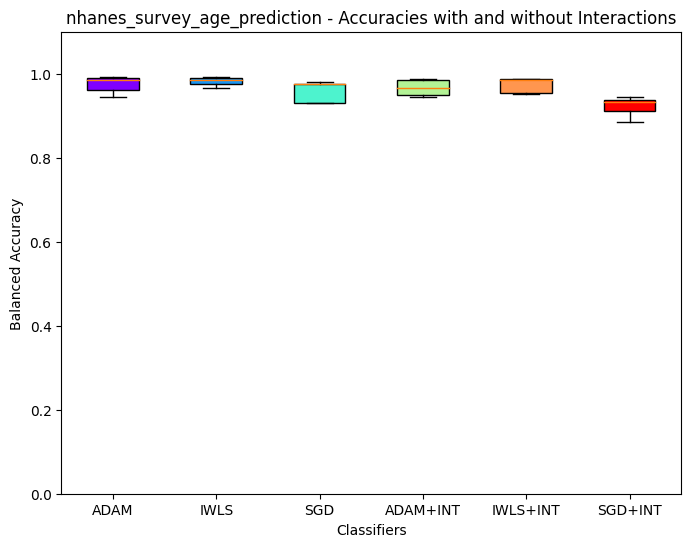

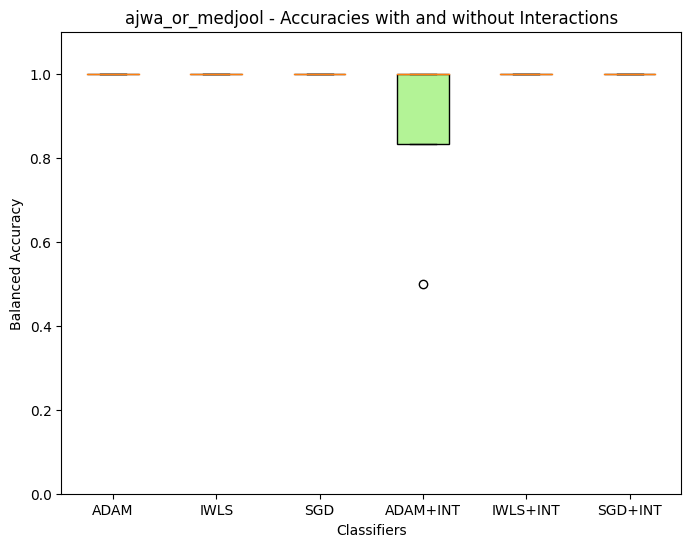

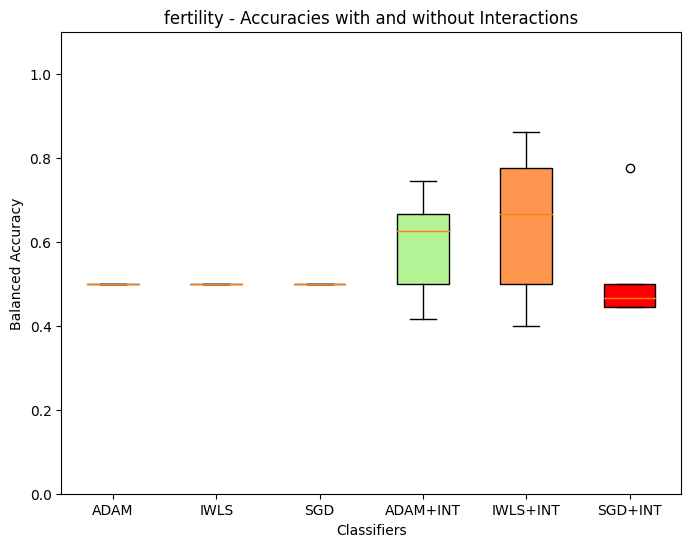

In [18]:
# Prepare data for plotting
Xs_train_int = {}
Xs_test_int = {}

for file_name in file_names:
    # Disregard large datasets
    if file_name not in ['nhanes_survey_age_prediction', 'ajwa_or_medjool', 'fertility']:
        continue

    # Initialize lists to store accuracies for each split
    custom_adam_accs = []
    custom_iwls_accs = []
    custom_sgd_accs = []

    custom_adam_accs_int = []
    custom_iwls_accs_int = []
    custom_sgd_accs_int = []

    for i in range(num_splits):
        # Run experiments without interactions

        adam = ADAM(batch_size=batch_size)
        iwsl = IWLS()
        sgd = SGD(batch_size=batch_size)

        custom_adam_acc, _ = run_custom_optimizer_experiment(
            adam, Xs_train[i][file_name], ys_train[i][file_name], Xs_test[i][file_name], ys_test[i][file_name], tolerance, max_epochs
        )
        custom_iwls_acc, _ = run_custom_optimizer_experiment(
            iwsl, Xs_train[i][file_name], ys_train[i][file_name], Xs_test[i][file_name], ys_test[i][file_name], tolerance, max_epochs
        )
        custom_sgd_acc, _ = run_custom_optimizer_experiment(
            sgd, Xs_train[i][file_name], ys_train[i][file_name], Xs_test[i][file_name], ys_test[i][file_name], tolerance, max_epochs
        )

        # Generate interactions
        Xs_train_int[file_name] = generate_interactions(Xs_train[i][file_name])
        Xs_test_int[file_name] = generate_interactions(Xs_test[i][file_name])

        adam = ADAM(batch_size=batch_size)
        iwsl = IWLS()
        sgd = SGD(batch_size=batch_size)

        # Run experiments with interactions
        custom_adam_acc_int, _ = run_custom_optimizer_experiment(
            adam, Xs_train_int[file_name], ys_train[i][file_name], Xs_test_int[file_name], ys_test[i][file_name], tolerance, max_epochs
        )
        custom_iwls_acc_int, _ = run_custom_optimizer_experiment(
            iwsl, Xs_train_int[file_name], ys_train[i][file_name], Xs_test_int[file_name], ys_test[i][file_name], tolerance, max_epochs
        )
        custom_sgd_acc_int, _ = run_custom_optimizer_experiment(
            sgd, Xs_train_int[file_name], ys_train[i][file_name], Xs_test_int[file_name], ys_test[i][file_name], tolerance, max_epochs
        )

        # Save results
        custom_adam_accs.append(custom_adam_acc)
        custom_iwls_accs.append(custom_iwls_acc)
        custom_sgd_accs.append(custom_sgd_acc)

        custom_adam_accs_int.append(custom_adam_acc_int)
        custom_iwls_accs_int.append(custom_iwls_acc_int)
        custom_sgd_accs_int.append(custom_sgd_acc_int)

    # Plot boxplots for accuracies with and without interactions

    colors = plt.cm.rainbow(np.linspace(0, 1, 6))


    plt.figure(figsize=(8, 6))
    box = plt.boxplot([custom_adam_accs, custom_iwls_accs, custom_sgd_accs, custom_adam_accs_int, custom_iwls_accs_int, custom_sgd_accs_int], patch_artist=True)
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.xlabel('Classifiers')
    plt.ylabel('Balanced Accuracy')
    plt.title(f"{file_name} - Accuracies with and without Interactions")
    plt.xticks([1, 2, 3, 4, 5, 6], ['ADAM', 'IWLS', 'SGD', 'ADAM+INT', 'IWLS+INT', 'SGD+INT'])
    plt.ylim(0, 1.1)
    plt.savefig(f"outputs/{file_name}_accur_interactions.pdf", bbox_inches='tight')
    plt.show()